# Modelo de Recomendación
En este notebook, puedes revisar el proceso paso a paso para construir nuestros dos modelos de recomendación:
<br>
1. **Item - Item** utilizando Filtrado Colaborativo.
2. **User - item** para esto creamos nuestro modelo utilizando Similitud Coseno y Modelo de Aprendizaje Automático KNN.
<br>
Las funciones que creamos son las solicitadas:<br>

>A. **Find Similar Games to the one we input**: Ingresamos un juego y, basándonos en las críticas y calificaciones de los usuarios, encuentra una lista de usuarios con gustos similares (usuarios similares que calificaron con 5 el juego ingresado) y, en función de estos usuarios, calificamos los juegos que a estos usuarios les gustaron y proporcionamos una lista de 5 juegos para recomendar.<br>
>B. **Find Similar Games to the User we input**: Ingresamos un user_id y, en función de las similitudes del usuario con otros usuarios y calificaciones, utilizando filtrado colaborativo proporcionamos una lista de 5 juegos similares a los juegos que al usuario ingresado le podrían gustar.
<br>

In [2]:
import pandas as pd
import numpy as np

# 1. Filtrado Colaborativo
El filtrado colaborativo es una técnica popular utilizada en sistemas de recomendación para hacer predicciones automáticas (filtrado) sobre los intereses de un usuario al recopilar información de preferencias o gustos de muchos usuarios (colaboración). La idea básica detrás del filtrado colaborativo es recomendar elementos a un usuario en función de las preferencias de otros usuarios que tienen gustos o preferencias similares.

Hay dos tipos principales de filtrado colaborativo:

- Filtrado colaborativo basado en **User-based**: En este enfoque, el sistema recomienda elementos a un usuario en función de las preferencias de otros usuarios que son similares a ese usuario. El sistema identifica usuarios similares al comparar sus calificaciones o comportamientos en elementos.

- Filtrado colaborativo basado en **Item-based**: En este enfoque, el sistema recomienda elementos a un usuario en función de las similitudes entre elementos. El sistema identifica elementos similares mediante el análisis de las calificaciones o comportamientos de los usuarios en esos elementos.

Tanto el filtrado colaborativo basado en usuarios como en elementos dependen de la noción de similitud entre usuarios o elementos. Métricas de similitud como la similitud de coseno, la correlación de Pearson o la similitud de Jaccard a menudo se utilizan para medir la similitud entre usuarios o elementos.
En nuestro proyecto, utilizamos la similitud de coseno por su simplicidad y buen rendimiento.

**El filtrado colaborativo no requiere ninguna información sobre los elementos o usuarios en sí; en cambio, se basa únicamente en las interacciones pasadas o calificaciones de los usuario**


In [49]:
# Definimos el path donde se encuentra el archivo .parquet qye utilizaremos
games = 'data/games1.parquet'

# Leemos a un pada DataFrame la información
df_games1 = pd.read_parquet(games)

In [50]:
df_games1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22528 entries, 0 to 22527
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   item_id                22528 non-null  int32  
 1   item_name              22528 non-null  object 
 2   developer              22528 non-null  object 
 3   publisher              22528 non-null  object 
 4   release_year           22494 non-null  Int64  
 5   price                  22528 non-null  float64
 6   genres                 22528 non-null  object 
 7   action                 22528 non-null  int64  
 8   adventure              22528 non-null  int64  
 9   animation modeling     22528 non-null  int64  
 10  audio production       22528 non-null  int64  
 11  casual                 22528 non-null  int64  
 12  design illustration    22528 non-null  int64  
 13  early access           22528 non-null  int64  
 14  education              22528 non-null  int64  
 15  fr

### Paso 1- Creamos un motor de búsqueda<br>

### Función para limpiar item_name (Títulos de juegos) con REGEX
Para esto, crearemos una función para limpiar el título de nuestro conjunto de datos. Esto significa que la columna de título de nuestro conjunto de datos será la entrada y la salida será una cadena limpia de caracteres especiales. Esto será la entrada de nuestro motor de búsqueda.

In [5]:
import re
def clean_title(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

In [6]:
df_games1['clean_title'] = df_games1['item_name'].apply(clean_title)

In [7]:
df_games1

,item_id,item_name,developer,publisher,release_year,price,genres,action,adventure,animation modeling,...,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing,clean_title
0,761140,Lost Summoner Kitty,Kotoshiro,Kotoshiro,2018,4.99,"action, casual, indie, simulation, strategy",1,0,0,...,0,0,1,0,0,1,0,0,0,Lost Summoner Kitty
1,643980,Ironbound,Secret Level SRL,"Making Fun, Inc.",2018,0.00,"free to play, indie, rpg, strategy",0,0,0,...,0,1,0,0,0,1,0,0,0,Ironbound
2,670290,Real Pool 3D - Poolians,Poolians.com,Poolians.com,2017,0.00,"casual, free to play, indie, simulation, sports",0,0,0,...,0,0,1,0,1,0,0,0,0,Real Pool 3D Poolians
3,767400,弹炸人2222,彼岸领域,彼岸领域,2017,0.99,"action, adventure, casual",1,1,0,...,0,0,0,0,0,0,0,0,0,2222
4,772540,Battle Royale Trainer,Trickjump Games Ltd,Trickjump Games Ltd,2018,3.99,"action, adventure, simulation",1,1,0,...,0,0,1,0,0,0,0,0,0,Battle Royale Trainer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22523,745400,Kebab it Up!,Bidoniera Games,Bidoniera Games,2018,1.99,"action, adventure, casual, indie",1,1,0,...,0,0,0,0,0,0,0,0,0,Kebab it Up
22524,773640,Colony On Mars,"Nikita ""Ghost_RUS""",Ghost_RUS Games,2018,1.99,"casual, indie, simulation, strategy",0,0,0,...,0,0,1,0,0,1,0,0,0,Colony On Mars
22525,733530,LOGistICAL: South Africa,Sacada,Sacada,2018,4.99,"casual, indie, strategy",0,0,0,...,0,0,0,0,0,1,0,0,0,LOGistICAL South Africa
22526,610660,Russian Roads,Laush Dmitriy Sergeevich,Laush Studio,2018,1.99,"indie, racing, simulation",0,0,0,...,1,0,1,0,0,0,0,0,0,Russian Roads


### Creando una Matriz TFIDF
Para ello se utilizo la libreria scikit-learn<br>
Utilizando la libreria sklearn, en particular el metodo TfidfVectorizer. Se crea el motor de busqueda para que ingresando un titulo de un juego, nos devuelva 5 titulos similares al que ingresamos.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf = vectorizer.fit_transform(df_games1['clean_title'])

## Creando el motor de búsqueda
Para el titulo de los games

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
# El input sera el nombre de un juego del que queramos la recomendación 
def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:] # lista las primeras cinco similitudes
    results = df_games1.iloc[indices][::-1]
    return results

In [10]:
search("Colony On Mars")

,item_id,item_name,developer,publisher,release_year,price,genres,action,adventure,animation modeling,...,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing,clean_title
22524,773640,Colony On Mars,"Nikita ""Ghost_RUS""",Ghost_RUS Games,2018,1.99,"casual, indie, simulation, strategy",0,0,0,...,0,0,1,0,0,1,0,0,0,Colony On Mars
6202,244030,Take On Mars,Bohemia Interactive,Bohemia Interactive,2017,26.99,simulation,0,0,0,...,0,0,1,0,0,0,0,0,0,Take On Mars
13827,509450,Colony,Jamie Cunningham,Varitech,2016,0.99,"casual, simulation",0,0,0,...,0,0,1,0,0,0,0,0,0,Colony
8948,720060,Colony,eugeniy_kh,eugeniy_kh,2017,1.99,"indie, simulation, strategy",0,0,0,...,0,0,1,0,0,1,0,0,0,Colony
16970,414210,GASP - Life on Mars,Dark Day Interactive,Dark Day Interactive,2015,2.99,"action, casual, free to play, indie, simulatio...",1,0,0,...,0,0,1,0,0,1,0,0,0,GASP Life on Mars


In [11]:
df_games1[df_games1['item_id'] == 730]

,item_id,item_name,developer,publisher,release_year,price,genres,action,adventure,animation modeling,...,racing,rpg,simulation,software training,sports,strategy,utilities,video production,web publishing,clean_title
942,730,Counter-Strike: Global Offensive,Valve,Valve,2012,14.99,action,1,0,0,...,0,0,0,0,0,0,0,0,0,CounterStrike Global Offensive


### Construyendo una Caja de Búsqueda Interactiva con Jupyter widgets

In [12]:
import ipywidgets as widgets
from IPython.display import display

games_input = widgets.Text(
    value = "Transistor",
    description = 'Game Title:',
    disabled = False
)

game_list = widgets.Output()

def on_type(data):
    with game_list: 
        game_list.clear_output()
        title = data['new']
        if len(title) > 5:
            display(search(title))
        
games_input.observe(on_type, names= 'value')

display(games_input, game_list)

Text(value='Transistor', description='Game Title:')

Output()

### Cargamos Review de reviews.parquet

In [13]:
# Se define el  file path desde donde se carga el .parquet file
reviews = 'data/reviews_eda.parquet'

# Leemos el .parquet a pandas DataFrame
df_reviews = pd.read_parquet(reviews)

In [14]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58400 entries, 0 to 58399
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    58400 non-null  object        
 1   user_url   58400 non-null  object        
 2   item_id    58400 non-null  int64         
 3   recommend  58400 non-null  bool          
 4   date       58400 non-null  datetime64[ns]
 5   year       58400 non-null  int32         
 6   sentiment  58400 non-null  int64         
 7   rate       58400 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int32(1), int64(2), object(2)
memory usage: 3.0+ MB


## Transformación de Revisiones
### Necesitamos transformar las revisiones de nuestros usuarios, el resultado del botón de recomendación y la calificación de útil (donde otros usuarios calificaron la revisión) en una calificación para alimentar nuestro sistema de recomendación.<br>
Para esto creamos una función que considerará los tres elementos, cuando existan y promediará una calificación que exprese la revisión del usuario en números.<br>
En general, esta función asigna una puntuación de calificación en función de los valores proporcionados para 'rate', 'sentiment' y 'recommend', considerando diferentes combinaciones de estos valores y siguiendo reglas específicas.<br>
*   Si la columna 'rate' es mayor que 0:
        -Si la columna 'recommend' es 0:
            -Si la columna 'sentiment' es 0, la puntuación de calificación se establece en 0.
            -Si la columna 'sentiment' es 1, la puntuación de calificación se calcula como 50 veces el 'rate'.
            -Si la columna 'sentiment' es 2, la puntuación de calificación se calcula como 75 veces el 'rate'.
        -Si la columna 'recommend' es 1:
            -Si la columna 'sentiment' es 0, la puntuación de calificación se calcula como 50 veces el 'rate'.
            -Si la columna 'sentiment' es 1, la puntuación de calificación se calcula como 75 veces el 'rate'.
            -Si la columna 'sentiment' es 2, la puntuación de calificación se calcula como 100 veces el 'rate'.
*   Si la columna 'rate' es 0:
    - Si la columna 'recommend' es 0:
        - Si la columna 'sentiment' es 0, la puntuación de calificación se establece en 0.
        - Si la columna 'sentiment' es 1, la puntuación de calificación se establece en 50.
        - Si la columna 'sentiment' es 2, la puntuación de calificación se establece en 75.
    - Si la columna 'recommend' es 1:
        - Si la columna 'sentiment' es 0, la puntuación de calificación se establece en 50.
        - Si la columna 'sentiment' es 1, la puntuación de calificación se establece en 75.
        - Si la columna 'sentiment' es 2, la puntuación de calificación se establece en 100
Luego normalizamos esta calificación en una puntuación de 1 a 5.<br>

In [15]:
# This function maps three input columns—'rate', 'sentiment', and 'recommend'—to a single rating score.
def map_to_rating(rate, sentiment, recommend):
    rate = rate/100
    if rate > 0:
        if recommend == 0:
            if sentiment == 0:
                return 0
            elif sentiment == 1:
                return 50 * rate
            else:  # sentiment == 2
                return 75 * rate
        else:  # recommend == 1
            if sentiment == 0:
                return 50 * rate
            elif sentiment == 1:
                return 75 * rate
            else:  # sentiment == 2
                return 100 * rate
    else:  # rate == 0
        if recommend == 0:
            if sentiment == 0:
                return 0
            elif sentiment == 1:
                return 50
            else:  # sentiment == 2
                return 75
        else:  # recommend == 1
            if sentiment == 0:
                return 50
            elif sentiment == 1:
                return 75
            else:  # sentiment == 2
                return 100

In [16]:
df_reviews_copy = df_reviews.copy()
# Aplicamos las  funcion  de mapping para crear una nueva columna  'rating' con el score calculado propuesto
df_reviews_copy['rating'] = df_reviews_copy.apply(lambda row: map_to_rating(row['rate'], row['sentiment'], row['recommend']), axis=1)

# Visibilizar el  DataFrame con la nueva columna 'rating'
df_reviews_copy[['rate', 'sentiment', 'recommend', 'rating']]

,rate,sentiment,recommend,rating
0,0.0,2,True,100.0
1,0.0,2,True,100.0
2,0.0,2,True,100.0
3,75.0,2,True,75.0
4,0.0,2,True,100.0
...,...,...,...,...
58395,0.0,2,True,100.0
58396,0.0,2,True,100.0
58397,50.0,2,True,50.0
58398,0.0,1,True,75.0


### Adicionalmente, para poder utilizar esta valiosa información por el modelo de Recomendación procedo a normalizar la columna en un ranking de 1 a 5, siendo 5 la mejor calificacion (recomendado y sentiment==2 y rating 100) y 1 la menor calificación (sentiment == 0, recomender == False y rating == 0)

In [17]:
def normalize_rating(rating):
    if rating < 20:
        return 1
    elif rating < 40:
        return 2
    elif rating < 60:
        return 3
    elif rating < 80:
        return 4
    else:  # rating < 100
        return 5

In [18]:
# Normalizamos la columna 'rating' con la funcion creada
df_reviews_copy['rating'] = df_reviews_copy['rating'].apply(normalize_rating)

In [19]:
df_reviews_copy['rating'].value_counts()

rating
5    21099
4    20764
3     8761
2     4471
1     3305
Name: count, dtype: int64

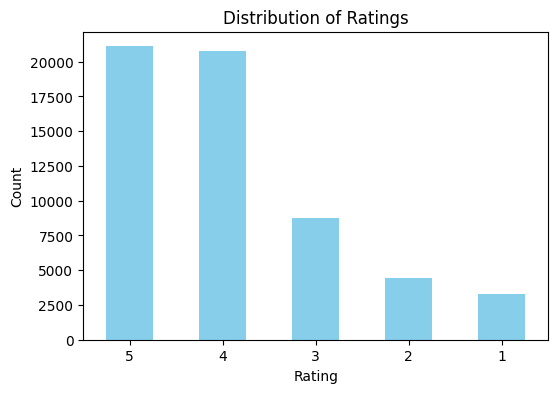

In [20]:
import matplotlib.pyplot as plt

# Preparamos la columna 'rating' filtrando para visualizr la distribucion de la clasificación obtenida
rating_counts = df_reviews_copy['rating'].value_counts()

# Plotting
plt.figure(figsize=(6, 4))
rating_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [21]:
df_reviews = df_reviews_copy

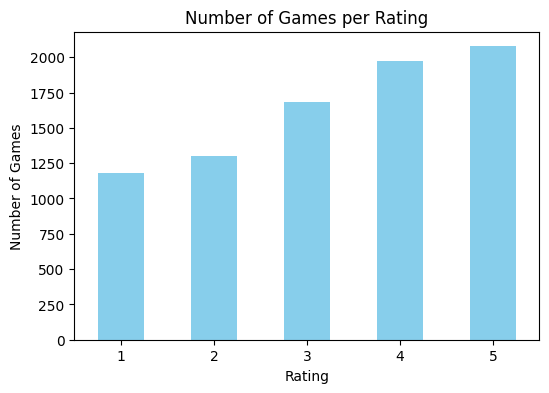

In [22]:
# Agrupamos el DataFrame por 'rating' y vemos la distribución de la calificación por  juegos
games_per_rating = df_reviews.groupby('rating')['item_id'].nunique()

# Plotting
plt.figure(figsize=(6, 4))
games_per_rating.plot(kind='bar', color='skyblue')
plt.title('Number of Games per Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Games')
plt.xticks(rotation=0)
plt.show()

In [23]:
df_reviews['item_id'].value_counts()

item_id
730       3704
440       3691
4000      1704
570       1541
218620    1112
          ... 
33100        1
312720       1
449980       1
32770        1
431510       1
Name: count, Length: 3682, dtype: int64

In [118]:
df_reviews['user_id'].value_counts()

user_id
lachlantatton        10
Astrelt              10
danthettt            10
Foxxy346             10
originaldog          10
                     ..
_maximus              1
maxstupo              1
maxy21                1
76561198085144241     1
76561198071781219     1
Name: count, Length: 25446, dtype: int64

In [24]:
df_reviews[(df_reviews['rating']>=5) & (df_reviews['item_id'] == 730)]

,user_id,user_url,item_id,recommend,date,year,sentiment,rate,rating
20,maplemage,http://steamcommunity.com/id/maplemage,730,True,2014-03-14,2014,2,100.0,5
28,MeaTCompany,http://steamcommunity.com/id/MeaTCompany,730,True,2024-07-24,2024,2,0.0,5
81,76561198061252210,http://steamcommunity.com/profiles/76561198061...,730,True,2015-05-21,2015,2,0.0,5
172,whiteofwolfing,http://steamcommunity.com/id/whiteofwolfing,730,True,2015-05-22,2015,2,100.0,5
200,StelerForYou,http://steamcommunity.com/id/StelerForYou,730,True,2015-07-17,2015,2,100.0,5
...,...,...,...,...,...,...,...,...,...
58279,BBiiiirr,http://steamcommunity.com/id/BBiiiirr,730,True,2015-02-02,2015,2,0.0,5
58332,76561198229845636,http://steamcommunity.com/profiles/76561198229...,730,True,2024-08-23,2024,2,100.0,5
58351,76561198251328528,http://steamcommunity.com/profiles/76561198251...,730,True,2024-02-12,2024,2,0.0,5
58365,SenpaiDemon,http://steamcommunity.com/id/SenpaiDemon,730,True,2024-01-05,2024,2,100.0,5


## Recomendar una lista de 5 juegos basada en un juego
Nos proponemos crear una función que, aplicando filtrado interactivo y colaborativo, proporcionará una lista de 5 juegos basada en una entrada.
En esta primera función, la entrada es el item_id, que es el identificador del juego.

## Encontrar usuarios que les gustó el mismo juego

In [25]:
game_id = 730

#### We look for all users who reviewed the game selected with a rating of 5.

In [26]:
similar_users = df_reviews[(df_reviews['item_id'] == game_id) & (df_reviews['rating']>=5)]['user_id'].unique()

In [27]:
# for Counter-Strike there are 1179 users that rated the game a 5
similar_users 

array(['maplemage', 'MeaTCompany', '76561198061252210', ...,
       '76561198251328528', 'SenpaiDemon', 'Fuckfhaisjnsnsjakaka'],
      dtype=object)

#### Now we filter the DataFrame df_reviews to select games that have been highly rated (5) by users who are similar to a target users (users how rated Counter-Strike 5)

In [28]:
# Searching all the games rated 5 by similar users ( the 1179 users that rated 5 Counter-Strike) 
similar_user_recs = df_reviews[(df_reviews['user_id'].isin(similar_users)) & (df_reviews['rating'] > 4)]['item_id']

In [29]:
# Lists all games rated 5 by the 1179 users --> gives 355 games
similar_user_recs.value_counts()

item_id
730       1179
440         75
4000        56
304930      28
570         26
          ... 
200710       1
70400        1
22300        1
274900       1
12120        1
Name: count, Length: 355, dtype: int64

#### We calculate the relative frequency of each game the users similar to us rate 

In [30]:
# We calculate the relative frequency of each game the users similar to us rate 
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

#### similar_users_recs now contains the relative frequency of each game among the recommendations of similar users
This is to narrow down the selection of the recommendations, this is we want the games that ranl higher in the amount of rating = 5, from the total amount of games that match our filter (we are stting this to 1% if there were more records, we could make this 10%) --> threshold 1% 

In [31]:
# similar_user_recs now contains the relative frequency of each game among the recommendations of similar users, we filter for the 1%
similar_user_recs = similar_user_recs[similar_user_recs > .01]
similar_user_recs

item_id
730       1.000000
440       0.063613
4000      0.047498
304930    0.023749
570       0.022053
218620    0.018660
252490    0.015267
222880    0.015267
105600    0.014419
550       0.013571
49520     0.013571
218230    0.013571
230410    0.012723
Name: count, dtype: float64

### Finding How much all users like this games
Some of this games are games generally liked. <br>
We want to find games that are similar to the game they liked, so that they are specific to our game and users<br>
We want games similar to Counter-Strike (730) not just random games that this users happen to like<br>
That is what we want to find<br>

In [32]:
# select users where the 'item_id' is present in the games list from our similar_users
all_users = df_reviews[(df_reviews['item_id'].isin(similar_user_recs.index)) & (df_reviews['rating']>4)]

In [33]:
# this are all users who liked games that were recommended to us (5916 users)
all_users

,user_id,user_url,item_id,recommend,date,year,sentiment,rate,rating
20,maplemage,http://steamcommunity.com/id/maplemage,730,True,2014-03-14,2014,2,100.0,5
24,Wackky,http://steamcommunity.com/id/Wackky,550,True,2012-10-21,2012,2,100.0,5
28,MeaTCompany,http://steamcommunity.com/id/MeaTCompany,730,True,2024-07-24,2024,2,0.0,5
38,death-hunter,http://steamcommunity.com/id/death-hunter,4000,True,2014-02-19,2014,2,0.0,5
40,DJKamBer,http://steamcommunity.com/id/DJKamBer,570,True,2013-04-27,2013,2,0.0,5
...,...,...,...,...,...,...,...,...,...
58341,pigeonie,http://steamcommunity.com/id/pigeonie,440,True,2015-09-04,2015,2,100.0,5
58351,76561198251328528,http://steamcommunity.com/profiles/76561198251...,730,True,2024-02-12,2024,2,0.0,5
58365,SenpaiDemon,http://steamcommunity.com/id/SenpaiDemon,730,True,2024-01-05,2024,2,100.0,5
58367,Fuckfhaisjnsnsjakaka,http://steamcommunity.com/id/Fuckfhaisjnsnsjakaka,730,True,2024-01-17,2024,2,0.0,5


#### Find what percentage of all users recommend this games

In [34]:
# calculates the  percentage from all users that recommend this games 
# high percentage shows that the games is liked by most of the users who rated the game 5)
all_users_recs = all_users['item_id'].value_counts() / len(all_users['user_id'].unique())

In [35]:
# We want higher percentage 
all_users_recs

item_id
440       0.271459
730       0.231585
4000      0.134551
570       0.090945
304930    0.073856
105600    0.065999
218620    0.054213
252490    0.053231
49520     0.050874
230410    0.047928
550       0.040267
218230    0.029857
222880    0.017285
Name: count, dtype: float64

### Creating a recommendation score

In [36]:
# We are going to compare the percentages for all this games to choose the best recommendation
rec_percentages = pd.concat([similar_user_recs,all_users_recs], axis=1)
rec_percentages.columns = ['similar','all']

### This shows  each of the games that were recommended to us (based on the game 730)  and how much users similar to us liked them versus  how much general users liked them 

In [37]:
# how much users similar to us liked them versus how much general users liked them
rec_percentages

,similar,all
item_id,,
730,1.000000,0.231585
440,0.063613,0.271459
4000,0.047498,0.134551
304930,0.023749,0.073856
570,0.022053,0.090945
218620,0.018660,0.054213
252490,0.015267,0.053231
222880,0.015267,0.017285
105600,0.014419,0.065999


In [38]:
# Finding the ratio betwen this percentages --> score
rec_percentages['score'] = rec_percentages['similar']/rec_percentages['all']
# The largest values will be display at the top
rec_percentages = rec_percentages.sort_values('score', ascending= False)
rec_percentages

,similar,all,score
item_id,,,
730,1.000000,0.231585,4.318066
222880,0.015267,0.017285,0.883241
218230,0.013571,0.029857,0.454533
4000,0.047498,0.134551,0.353010
218620,0.018660,0.054213,0.344194
550,0.013571,0.040267,0.337020
304930,0.023749,0.073856,0.321558
252490,0.015267,0.053231,0.286809
49520,0.013571,0.050874,0.266753


In [39]:
# We are going to merge our 10 top recomendations with the df_games
rec_percentages.head(10).merge(df_games1, left_index=True, right_on='item_id')[['item_id','score','item_name','genres']]

,item_id,score,item_name,genres
942,730,4.318066,Counter-Strike: Global Offensive,action
1649,222880,0.883241,Insurgency,"action, indie, strategy"
21076,218230,0.454533,PlanetSide 2,"action, free to play, massively multiplayer"
34,4000,0.353010,Garry's Mod,"indie, simulation"
22019,550,0.337020,Left 4 Dead 2,action
11738,304930,0.321558,Unturned,"action, adventure, casual, free to play, indie"
20371,252490,0.286809,Rust,"action, adventure, indie, massively multiplaye..."
21295,49520,0.266753,Borderlands 2,"action, rpg"
20838,230410,0.265455,Warframe,"action, free to play"


## Recommendation Functions
### 1. Find_Similar_Games(game)<br>
>We are going to put all this into a Function <br>
>So we get to input a game and receive a list of 5 recommended games.

In [55]:
def find_similar_games(game_id):

    similar_users = df_reviews[(df_reviews['item_id'] == game_id) & (df_reviews['rating']>=5)]['user_id'].unique()
    similar_user_recs = df_reviews[(df_reviews['user_id'].isin(similar_users)) & (df_reviews['rating'] > 4)]['item_id']

    #similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
    #similar_user_recs = similar_user_recs[similar_user_recs > .05]

    all_users = df_reviews[(df_reviews['item_id'].isin(similar_user_recs.index)) & (df_reviews['rating']>4)]
    all_users_recs = all_users['item_id'].value_counts() / len(all_users['user_id'].unique())

    rec_percentages = pd.concat([similar_user_recs,all_users_recs], axis=1)
    rec_percentages.columns = ['similar','all']

    rec_percentages['score'] = rec_percentages['similar']/rec_percentages['all']

    rec_percentages = rec_percentages.sort_values('score', ascending= False)
    return rec_percentages.head(6).merge(df_games1, left_index=True, right_on="item_id")[['item_id', 'score','item_name','genres']]

### Creamos un Widget Interactiv de Recommendación
Creamos un widget para desplegar el uso y resultado de nuestra función.<br>
Simplemente se requiere correr el codigo debajo y aparecerá un text box donde se puede ingresar un game_name cualquiera y el motor de busqueda proveerá los juegos recomendados<br>
## **Detección de Oportunidades**
Como el motor de búsqueda se basa en el df_games que tiene mas de 58K registros de la plataforma, juegos, pero la recomendación se hace en base a las reseñas de los usuarios, que solo cuenta con recomendaciones sobre 3.682 juegos, muchas veces no produce recomendaciones. Esto se debe a que faltaría completar o expandir la base de reseñas para así abarcar mayor cantidad de juegos.<br>
Cuando no produzca una recomendación no es por una falla de la función sino mas bien por una ineficiencia de los datos originales<br>
Esto podría mejorarse fácilmente y haría más asertivo al modelo, ya que se podría incrementar el threshold de similitudes al 10% (actualmente corre al 50%), entre otras posibilidades.
Al estar el modelo construído, solo hay que alimentarle bases de datos más amplias y mejoraría rápidamente la performance<br>

In [56]:
import ipywidgets as widgets
from IPython.display import display

game_name_input = widgets.Text(
    value='Transistor',
    description = 'Game Title:',
    disable = False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data['new']
        if len(title) > 5:
            results = search(title)
            item_id = results.iloc[0]['item_id']
            display(find_similar_games(item_id))
            
game_name_input.observe(on_type, names='value')

display(game_name_input, recommendation_list)

Text(value='Transistor', description='Game Title:')

Output()

### 2. Find_Similar_Games(user_id)<br>
Esta función, find_similar_games, toma como entrada un user_id y devuelve una lista de 5 juegos recomendados para ese usuario. Utiliza un enfoque de filtrado colaborativo para encontrar juegos que son populares entre usuarios similares al usuario dado. El proceso se puede resumir de la siguiente manera:
- Identifica otros usuarios que tienen gustos similares al usuario dado.
- Encuentra juegos que son populares entre estos usuarios similares.
- Calcula un puntaje para cada juego basado en su popularidad entre los usuarios similares.
- Devuelve los 5 juegos con los puntajes más altos como recomendaciones para el usuario dado.

Este enfoque permite recomendar juegos que son populares entre usuarios con gustos similares, lo que puede resultar en recomendaciones más relevantes y personalizadas para el usuario dado.

In [116]:
def find_user_recommendations(user_id):
    # Filtramos por los juegos con calificaciones de 5 para nuestro usuario
    user_highly_rated_games = df_reviews[(df_reviews['user_id'] == user_id) & (df_reviews['rating'] >= 5)]['item_id'].unique()
    
    # Encontramos otros usuarios que hayan calificado como 5 los juegos que nuestro usuario califico como 5 
    similar_users = df_reviews[(df_reviews['item_id'].isin(user_highly_rated_games)) & (df_reviews['rating'] >= 5)]['user_id'].unique()
    
    # De esta forma conseguimos calificaciones de usuarios similares
    similar_user_recs = df_reviews[(df_reviews['user_id'].isin(similar_users)) & (df_reviews['rating'] > 4)]['item_id']
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
    similar_user_recs = similar_user_recs[similar_user_recs > .01] # umbral que hace que la búsqueda de similitud funcione mejor
    
    # Ahora con esto, vamos a filtrar todas las recomendaciones de todos los usuarios
    all_users = df_reviews[(df_reviews['item_id'].isin(similar_user_recs.index)) & (df_reviews['rating'] > 4)]
    all_users_recs = all_users['item_id'].value_counts() / len(all_users['user_id'].unique())
    
    # Calcular puntajes y combinar con información del juego
    rec_percentages = pd.concat([similar_user_recs, all_users_recs], axis=1)
    rec_percentages.columns = ['similar', 'all']
    rec_percentages['score'] = rec_percentages['similar'] / rec_percentages['all']
    rec_percentages = rec_percentages.sort_values('score', ascending=False)
    
    # Combinar con información del juego y devolver las principales recomendaciones
    return rec_percentages.head(5).merge(df_games1, left_index=True, right_on="item_id")[['item_id', 'score', 'item_name', 'genres']]

In [117]:
find_user_recommendations('76561198070585472')

,item_id,score,item_name,genres


### Creando un Widget Interactivo de Recommendación 
Creamos un widget que cuando ingresamos el user_id de un usuario nos devuelve una lista con 5 recomendaciones 

In [138]:
user_id_input = widgets.Text(
    value='maplemage',
    description='User_Id:',
    disabled=False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        user_id = data['new']
        # if len(title) > 5:
            # Assuming search function returns game ID
        display(find_user_recommendations(user_id))  # Call the new function

user_id_input.observe(on_type, names='value')

display(user_id_input, recommendation_list)

Text(value='maplemage', description='User_Id:')

Output()

# 2. Recomendador Usuario - item con Aprendizaje Automático KNN 
Acá construímos un modelo de Recomendación pero utilizando similitud por coseno y una matriz csr construida a partir de los usuarios, los juegos y sus reseñas utilizando el algortimo de clasificación  KNN Vecinos Cercanos.
vamos a obtener una recomendación basada en las recomendaciones de otros usuarios.

#### 2.1 Data Preparation
Preparamos la informacion a utilizar para el desarrollo del modelo creando a partir de dataframe Reviews, una matriz csr. Para ello utilizamos la libreria scipy.

In [131]:
reviews = df_reviews.copy()

In [132]:
reviews.drop(['user_url','recommend','date','year','sentiment','rate'],axis=1 , inplace= True)

### Reshaping

In [122]:
# Creamos una matriz  apartir de reviews
games_users = reviews.pivot(index='item_id', columns= 'user_id', values= 'rating').fillna(0)
games_users.head(10)

user_id,--000--,--ace--,--ionex--,-2SV-vuLB-Kg,-Azsael-,-Beave-,-GM-Dragon,-I_AM_EPIC-,-Kenny,-Mad-,...,zumpo,zunbae,zuzuga2003,zv_odd,zvanik,zwanzigdrei,zy0705,zynxgameth,zyr0n1c,zzoptimuszz
item_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
# Importamos la libreria scipy para utilizar el modulo matrix dispersa que nos permitirá poder trabajar con una matriz de esta magnitud sin problemas
from scipy.sparse import csr_matrix

In [124]:
# Creamos una matriz dispersa de la matriz games_users
mat_games = csr_matrix(games_users.values)

Asignar el coseno como métrica en el modelo KNN significa que la búsqueda encuentra elementos de la matriz de juegos-usuarios con una similitud en cada calificación. Por lo tanto, ahora, dado un usuario o un elemento, buscará similitudes en la matriz de juegos y usuarios.

Se establece en "brute" para que la búsqueda itere en toda la matriz.

In [125]:
# Establecemos el modelo de vecinos más cercanos con métrica de coseno y algoritmo "brute"

from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(metric='cosine', algorithm='brute',n_neighbors=20 )
model.fit(mat_games)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [126]:
# fuzzywuzzy está mejorando nuestra búsqueda
from fuzzywuzzy import process

### 2.1 Función de Recomendación. Item - Item

Este modelo de recomendación utiliza el algoritmo de Vecinos más Cercanos (KNN) con similitud de coseno para sugerir juegos similares basados en las preferencias del usuario. El modelo opera mediante la creación de una matriz dispersa que representa las interacciones entre usuarios y juegos. Luego, calcula las similitudes entre juegos utilizando la distancia coseno e identifica los vecinos más cercanos para cada juego. Se utiliza la coincidencia difusa de cadenas para mejorar la coincidencia de nombres de juegos. Finalmente, el modelo devuelve una lista de juegos recomendados basados en el nombre del juego proporcionado como entrada.

In [127]:
def recommender(game_name):
    data = mat_games
    n = 6
    idx = process.extractOne(game_name, df_games1['item_name'])[2] # ahora solo devuelve la ubicación
    print('Game Title: ', df_games1['item_name'][idx], 'Index: ', idx)
    print('Searching for recommendation..............')
    distance, indices = model.kneighbors(data[idx], n_neighbors=n)
    
    for count, i in enumerate(indices):
        if count == n:  # Omitir el primer índice en la lista de visualización
            continue
        print(df_games1['item_name'][i])

In [102]:
recommender('Chronicles of Vinland')

Game Title:  Chronicles of Vinland Index:  28
Searching for recommendation..............
28                                  Chronicles of Vinland
245                 Killing Floor Outbreak Character Pack
1050                          Condemned: Criminal Origins
1229              Demolition Inc - Level &amp; Weapon DLC
2685    Assassin’s Creed® Rogue - Time Saver: Resource...
2118                                              Top Hat
Name: item_name, dtype: object


## 2.2  Lista de 5 recomendaciones de juegos en función a un usuario como input
Esta función, llamada "user_recommender", recomienda juegos para un usuario específico basándose en los juegos que el usuario ya ha jugado. Primero, verifica si el usuario está presente en el conjunto de datos de interacciones entre usuarios y juegos. Luego, encuentra los juegos que el usuario aún no ha jugado. Utiliza el algoritmo de los k vecinos más cercanos (KNN) para encontrar juegos similares a los que el usuario ha jugado. Finalmente, devuelve una lista de juegos recomendados para el usuario.

In [130]:
def user_recommender(user_id):
    
    if user_id in games_users.index:
        # Si el usuario está presente en los índices de los juegos
        user_index = games_users.index.get_loc(user_id)
        
        # Encuentra el índice correspondiente al user_id
        user_games = games_users.iloc[user_index]
        
        # Filtra los juegos que el usuario aún no ha jugado
        unseen_games = user_games[user_games == 0].index
        
        # Encuentra recomendaciones basadas en los juegos jugados por el usuario
        n = 5  # Número de recomendaciones
        distance, indices = model.kneighbors(user_games.values.reshape(1, -1), n_neighbors=n)
        
        # Extrae los índices de juegos recomendados
        recommended_indices = indices.flatten()[1:]  # Excluye los propios juegos del usuario
        
        # Obtiene los nombres de los juegos recomendados
        recommended_games = df_games1.loc[recommended_indices, 'item_name'].tolist()
        
        return recommended_games
    else:
        print(f"User with user_id {user_id} not found in the DataFrame.")
    

In [137]:
user_recommender('Astrelt')

User with user_id Astrelt not found in the DataFrame.


### Guardamos los Dataframe 
Ahora podemos guardar los  dataframes ya que estos serán los utilizados por las funcinoes que desarrollaremos en el 3.2 del  [Featuring Engineering](03.%20Feature%20Engineering.ipynb).
Elegí guardar los mismos en formato .parquet para optimizar el espacio <br>

In [106]:
# Define el  path donde se guardaran los .parquet file
RS_reviews = 'data/RS_reviews.parquet'
RS_games = 'data/RS_games.parquet'
ML_games_users = 'data/games_users.parquet'

# Guardamos los DataFrame como .parquet file
df_reviews.to_parquet(RS_reviews, index=False)
df_games1.to_parquet(RS_games, index=False)
games_users.to_parquet(ML_games_users, index=False)

# Imprimimos mensaje de confirmación 
print(f'reviews DataFrame was stored into {RS_reviews}')
print(f'games1 DataFrame was stored into {RS_games}')
print(f'games_users DataFrame was stored into {ML_games_users}')


reviews DataFrame was stored into data/RS_reviews.parquet
games1 DataFrame was stored into data/RS_games.parquet
games_users DataFrame was stored into data/games_users.parquet
